<a href="https://colab.research.google.com/github/ashekhar20/league_predict/blob/master/simple_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
base_url = 'https://raw.githubusercontent.com/ashekhar20/league_predict/master/data/'
data_dict=base_url+'data_dictionary.xlsx'
train_file=base_url+'train.csv'
test_file=base_url+'test.csv'

In [4]:
df1 = pd.read_csv(train_file)
df2 = pd.read_csv(test_file)
df1.shape, df2.shape

((252, 30), (76, 30))

In [5]:
cols=df1.columns
print(len(cols))
cols

30


Index(['Game ID', 'Team 1', 'Team 2', 'City', 'DayOfWeek', 'DateOfGame',
       'TimeOfGame', 'AvgWindSpeed', 'AvgHumidity',
       'Inn 1 Team 1 NOP R>25,SR>125', 'Inn 1 Team 1 NOP R<25, SR>125',
       'Inn 1 Team 1 Total 4s', 'Inn 1 Team 1 Total 6s',
       'Inn 1 Team 1 Max Strike Rate_ALLBatsmen',
       'Inn 1 Team 2 NoP fast bowlers', 'Inn 1 Team 2 NoP Spinners',
       'Inn 1 Team 2 wickets taken_catches_runout',
       'Inn1 Team 2 wickets taken_ bowled _lbw_caught by keeper_stumping',
       'Inn 1 Team 2 Extras conceded in_wides_No Balls',
       'Inn 2 Team 2 NOP R>25,SR>125', 'Inn 2 Team 2 NOP R<25, SR>125',
       'Inn 2 Team 2 Total 4s', 'Inn 2 Team 2 Total 6s',
       'Inn 2 Team 2 Max Strike Rate_ALLBatsmen',
       'Inn 2 Team 1 NoP fast bowlers', 'Inn 2 Team 1 NoP Spinners',
       'Inn 2 Team 1 wickets taken_catches_runout',
       'Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping',
       'Inn 2 Team 1 Extras conceded in_wides_No Balls',
       'Win

Check for any column mismatch in train and test data

In [6]:
print("In Train, not in Test:")
for c in set(df1.columns):
  if c not in set(df2.columns):
    print(c)
  
print("In Test, not in Train:")
for c in set(df2.columns):
  if c not in set(df1.columns):
    print(c)

In Train, not in Test:
DayOfWeek
City
In Test, not in Train:
Day
CityOfGame


In [0]:
# rename two columns in test to match those in train
df2.rename(columns={"Day": "DayOfWeek", "CityOfGame":"City"}, inplace=True)

In [0]:
def prepare_data(mydf):
  # Extract Year and Hour of the match
  mydf['DateTimeOfGame']=pd.to_datetime(mydf['DateOfGame']+'T'+mydf['TimeOfGame'])
  mydf['YearOfGame']=mydf['DateTimeOfGame'].dt.year
  mydf['HourOfGame']=mydf['DateTimeOfGame'].dt.hour
  
  # Is Home team batting first?
  mydf['isTeam1Home'] = mydf.apply(lambda x: x['City'] in x['Team 1'], axis=1)
  
  # Obtain match number for each team. 
  tmp1=mydf[['Team 1','YearOfGame','DateTimeOfGame']]
  tmp1.rename(columns={"Team 1": "Team"}, inplace=True)
  tmp2=mydf[['Team 2','YearOfGame','DateTimeOfGame']]
  tmp2.rename(columns={"Team 2": "Team"}, inplace=True)
  tmp=pd.concat([tmp1,tmp2])
  tt=tmp.groupby(['Team','YearOfGame'])["DateTimeOfGame"].rank("dense", ascending=True)
  tmp['TeamMatchNum']=tt.values.astype(int)
  tmp2=tmp.sort_values(by=['Team','DateTimeOfGame'])
  tmp2['match_key']=tmp2['Team']+tmp2['DateTimeOfGame'].astype(str)
  tmp2=tmp2.set_index('match_key')
  matchnum_dict=tmp2[['TeamMatchNum']].to_dict()
  # We'll update the main dataframe with TeamMatchNum using match_key (which is unique)
  # We'll create two new columns: Team1MatchNum and Team2MatchNum.
  mydf['match_key']=mydf['Team 1']+mydf['DateTimeOfGame'].astype(str)
  mydf['Team1MatchNum']=mydf['match_key'].map(matchnum_dict['TeamMatchNum'])
  mydf['match_key']=mydf['Team 2']+mydf['DateTimeOfGame'].astype(str)
  mydf['Team2MatchNum']=mydf['match_key'].map(matchnum_dict['TeamMatchNum'])
  
  # Now our dataframe is ready for training. We'll identify the columns to be selected 
  # and take a subset of the dataframe. We'll return X matrix and y vector
  feature_columns=['YearOfGame','HourOfGame','isTeam1Home',
       'Team1MatchNum','Team2MatchNum','AvgWindSpeed', 'AvgHumidity',
       'Inn 1 Team 1 NOP R>25,SR>125', 'Inn 1 Team 1 NOP R<25, SR>125',
       'Inn 1 Team 1 Total 4s', 'Inn 1 Team 1 Total 6s',
       'Inn 1 Team 1 Max Strike Rate_ALLBatsmen',
       'Inn 1 Team 2 NoP fast bowlers', 'Inn 1 Team 2 NoP Spinners',
       'Inn 1 Team 2 wickets taken_catches_runout',
       'Inn1 Team 2 wickets taken_ bowled _lbw_caught by keeper_stumping',
       'Inn 1 Team 2 Extras conceded in_wides_No Balls',
       'Inn 2 Team 2 NOP R>25,SR>125', 'Inn 2 Team 2 NOP R<25, SR>125',
       'Inn 2 Team 2 Total 4s', 'Inn 2 Team 2 Total 6s',
       'Inn 2 Team 2 Max Strike Rate_ALLBatsmen',
       'Inn 2 Team 1 NoP fast bowlers', 'Inn 2 Team 1 NoP Spinners',
       'Inn 2 Team 1 wickets taken_catches_runout',
       'Inn2 Team 1 wickets taken_ bowled _lbw_caught by keeper_stumping',
       'Inn 2 Team 1 Extras conceded in_wides_No Balls',
       ]
  dependent='Winner (team 1=1, team 2=0)'
  tmpdf=mydf[feature_columns]
  tdf=pd.get_dummies(tmpdf)
  X=tdf.to_numpy()
  y=mydf[dependent].values
  
  return X,y, tdf.columns


In [12]:
trainX, trainY, trcols = prepare_data(df1)
print(trainX.shape, trainY.shape)

(252, 27) (252,)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [13]:
testX, y_true, tecols = prepare_data(df2)
print(testX.shape, y_true.shape)

(76, 27) (76,)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [0]:
lr = LogisticRegression(solver='lbfgs', max_iter=2000)
rfc = RandomForestClassifier(n_estimators=100)
svm = SVC(C=1.0)

        pred 0  pred 1
true 0      40       2
true 1       5      29


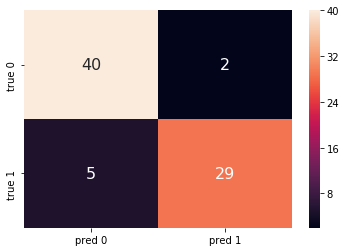

In [31]:
clf=lr
m=clf.fit(trainX, trainY)
y_pred=clf.predict(testX)
cm=confusion_matrix(y_true, y_pred)
cmdf=pd.DataFrame(cm,index=["true 0", "true 1"], columns=["pred 0", "pred 1"])
print(cmdf)
sns.heatmap(cmdf,annot=True,annot_kws={"size": 16})

In [39]:
for i,j in zip([lr, rfc, svc], ['lr', 'rfc', 'svc']):
  print(i,j)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) lr
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) rfc
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2

In [43]:
clfnames=['Logistic Regression', 'Random Forest Classifier', 'Support Vector Machine']
rep=[]
for clf, name in zip([lr, rfc, svc], clfnames):
  m=clf.fit(trainX, trainY)
  y_pred=clf.predict(testX)
  accuracy=accuracy_score(y_true, y_pred)
  precision=precision_score(y_true, y_pred)
  recall=recall_score(y_true, y_pred)
  f1=f1_score(y_true, y_pred)
  rep.append([name,accuracy,precision,recall,f1])

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [45]:
pd.DataFrame(rep, columns=['classifier', 'accuracy', 'precision', 'recall', 'f1_score']).set_index('classifier')

,accuracy,precision,recall,f1_score
classifier,,,,
Logistic Regression,0.907895,0.935484,0.852941,0.892308
Random Forest Classifier,0.881579,0.878788,0.852941,0.865672
Support Vector Machine,0.578947,1.000000,0.058824,0.111111


Additional features that could be added:


1.   number of changes from last match (for each year). Team that change a lot may be less prone to winning
2.  Past League performance

